In [1]:
import json
import networkx as nx
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict

In [2]:
def create_graph(file_path):
        with open(file_path) as f:
            data = json.load(f) 

        G = nx.DiGraph()   

        for node, attrs in data["nodes"].items():
            G.add_node(node, **attrs)  

        for edge_str, attrs in data["edges"].items():
            if "->" in edge_str:
                src, tgt = edge_str.split("->", 1)
                G.add_edge(src, tgt, weight=attrs.get('score', 0.0), **attrs)
            else:
                print(f"Warning: skipped malformed edge key: {edge_str}")
        return G

def get_graphs(results_folder: str):
    graph_data = defaultdict(dict)

    results_path = Path(results_folder)
    for rank_folder in results_path.rglob('*'):
        if not rank_folder.is_dir(): continue
        if 'lora_rank_' not in rank_folder.name: continue

        rank_id = rank_folder.name.split('lora_rank_')[-1]
        for checkpoint in rank_folder.rglob('*'):
            if not checkpoint.is_dir(): continue
            if 'checkpoint-' not in checkpoint.name: continue

            ckpt_id = checkpoint.name.split('checkpoint-')[-1]
            graph = create_graph(checkpoint / 'graph.json')
            graph_data[rank_id][ckpt_id] = graph

    return graph_data

### Standard Jaccard Sim between prompts

In [3]:
def topk_edges(G, k=None, return_scores=False):
    edges = [
        ((u, v), data.get('score', 0.0))
        for u, v, data in G.edges(data=True)
        if data.get('in_graph', False) is True
    ]
    if k is not None:
        edges = sorted(edges, key=lambda x: abs(x[1]), reverse=True)[:k]

    if return_scores:
        return {edge: score for edge, score in edges}
    else:
        return {edge for edge, _ in edges}
    
def topk_nodes(G, k=None):
    #TODO: Bug! will return 100% overlap if k given 
    if k is None:
        return {
            n for n, data in G.nodes(data=True)
            if data.get('in_graph', False) is True
        }
    else:
        sorted_nodes = sorted(
            G.nodes(data=True),
            key=lambda x: abs(x[1].get('score', 0.0)),
            reverse=True
        )
        return {n for n, _ in sorted_nodes[:k]}

def jaccard_overlap_score(G1, G2, k=None, overlap_type='edges'):
    if overlap_type == 'edges':
        A = topk_edges(G1, k)
        B = topk_edges(G2, k)
    elif overlap_type == 'nodes':
        A = topk_nodes(G1, k)
        B = topk_nodes(G2, k)
    else:
        raise ValueError(f"Invalid overlap_type: {overlap_type}. Use 'edges' or 'nodes'.")

    inter = A & B
    union = A | B
    sim = len(inter) / len(union) if union else 0.0

    return sim

def weighted_jaccard_overlap(G1, G2, k=None, overlap_type='edges'):
    if overlap_type == 'edges':
        A = topk_edges(G1, k, return_scores=True)
        B = topk_edges(G2, k, return_scores=True)
    elif overlap_type == 'nodes':
        A = topk_nodes(G1, k, return_scores=True)
        B = topk_nodes(G2, k, return_scores=True)
    else:
        raise ValueError(f"Invalid overlap_type: {overlap_type}. Use 'edges' or 'nodes'.")

    all_keys = set(A.keys()) | set(B.keys())
    numerator = sum(min(A.get(k, 0), B.get(k, 0)) for k in all_keys if k in A and k in B)
    denominator = sum(max(A.get(k, 0), B.get(k, 0)) for k in all_keys)

    return numerator / denominator if denominator else 0.0

In [4]:
graphs = get_graphs('results_run_2_20-100')

In [5]:
similarities = defaultdict(dict)

reference_graph = graphs['128']['100']

for rank_id, checkpoints in graphs.items():
    for checkpoint_id, graph in checkpoints.items():
        sim = weighted_jaccard_overlap(graph, reference_graph)
        similarities[rank_id][checkpoint_id] = sim

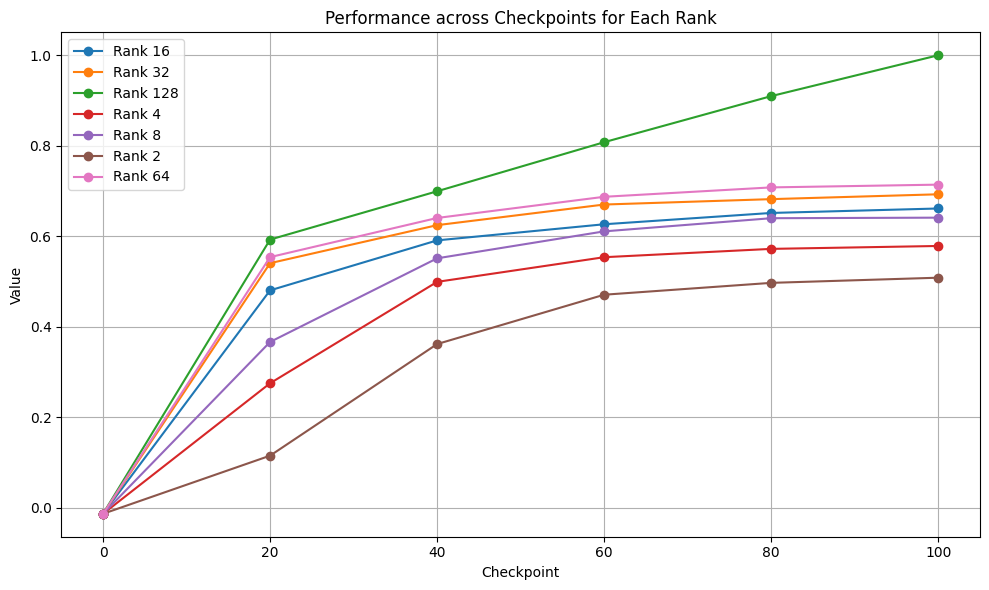

In [6]:
plt.figure(figsize=(10, 6))

checkpoints = sorted(next(iter(similarities.values())).keys(), key=int)

for rank, vals in similarities.items():
    y = [vals[cp] for cp in checkpoints]
    plt.plot(checkpoints, y, marker='o', label=f'Rank {rank}')

plt.xlabel("Checkpoint")
plt.ylabel("Value")
plt.title("Performance across Checkpoints for Each Rank")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
import os
def get_checkpoint_folders(results_folder: str):
    graph_data = defaultdict(dict)

    results_path = Path(results_folder)
    for rank_folder in results_path.rglob('*'):
        if not rank_folder.is_dir(): continue
        if 'lora_rank_' not in rank_folder.name: continue

        rank_id = rank_folder.name.split('lora_rank_')[-1]
        for checkpoint in rank_folder.rglob('*'):
            if not checkpoint.is_dir(): continue
            if 'checkpoint-' not in checkpoint.name: continue

            ckpt_id = checkpoint.name.split('checkpoint-')[-1]
            graph_data[rank_id][ckpt_id] = checkpoint / 'graph.json'

    return graph_data

In [4]:
folders = get_checkpoint_folders('results_run_2_20-100')

In [ ]:
def calculate_in_graph_changes_top_percentile(checkpoints, percentile=95):
    edge_scores = []

    for checkpoint in checkpoints:
        for edge, data in checkpoint['edges'].items():
            if 'score' in data:  # or any numerical metric
                edge_scores.append(data['score'])

    if not edge_scores:
        return [0] * (len(checkpoints) - 1)  # fallback


    threshold = np.percentile(edge_scores, percentile)

    in_graph_changes = []

    for i in range(1, len(checkpoints)):
        prev_edges = checkpoints[i - 1]['edges']
        curr_edges = checkpoints[i]['edges']
        change_count = 0

        for edge, curr_data in curr_edges.items():
            score = curr_data.get('score', 0)

            if score < threshold:
                continue  # skip edges not in 95th percentile

            prev_in_graph = prev_edges.get(edge, {}).get('in_graph', False)
            curr_in_graph = curr_data['in_graph']

            if prev_in_graph != curr_in_graph:
                change_count += 1

        in_graph_changes.append(change_count)

    return in_graph_changes

In [6]:
edge_changes = defaultdict(dict)

for rank_id, checkpoints in folders.items():
    sorted_keys = sorted(checkpoints.keys(), key=int)
    sorted_paths = [str(checkpoints[k]) for k in sorted_keys]
    
    graphs = []
    for path in sorted_paths:
        with open(path, 'r') as f:
            data = json.load(f)
            graphs.append(data)

    changes_for_rank = calculate_in_graph_changes_top_percentile(graphs)
    print(f"Edge changes for rank {rank_id}:", changes_for_rank)

    edge_changes[rank_id] = changes_for_rank 

Edge changes for rank 16: [1835, 1252, 711, 511, 317]
Edge changes for rank 32: [1942, 1168, 655, 560, 381]
Edge changes for rank 128: [2187, 1286, 993, 757, 420]
Edge changes for rank 4: [1696, 1414, 830, 464, 218]
Edge changes for rank 8: [1782, 1408, 698, 493, 253]
Edge changes for rank 2: [1466, 1489, 916, 417, 147]
Edge changes for rank 64: [1974, 1234, 833, 618, 280]


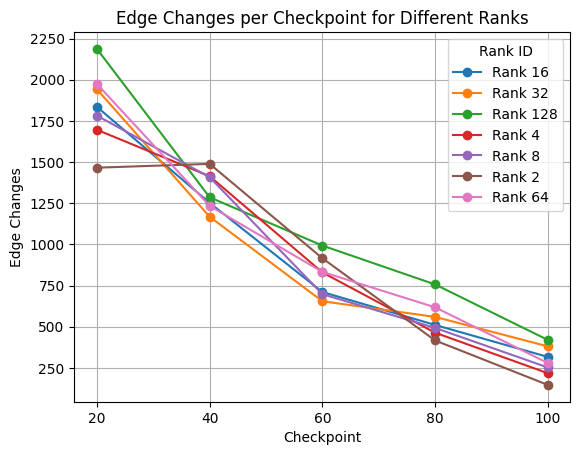

In [7]:
checkpoints = ['20', '40', '60', '80','100']

for rank_id, values in edge_changes.items():
    plt.plot(checkpoints, values, marker='o', label=f'Rank {rank_id}')

plt.xlabel('Checkpoint')
plt.ylabel('Edge Changes')
plt.title('Edge Changes per Checkpoint for Different Ranks')
plt.legend(title='Rank ID')
plt.grid(True)
plt.show()

In [ ]:
node_changes = defaultdict(dict)

def calculate_node_changes(checkpoints):
    changes = []
    added_ls = []
    removed_ls = []
    for i in range(1, len(checkpoints)):
        prev_nodes = checkpoints[i - 1]['nodes']
        curr_nodes = checkpoints[i]['nodes']
        added = sum(
            1 for node in curr_nodes
            if curr_nodes[node].get('in_graph', False) and not prev_nodes.get(node, {}).get('in_graph', False)
        )       

        removed = sum(
            1 for node in prev_nodes
            if prev_nodes[node].get('in_graph', False) and not curr_nodes.get(node, {}).get('in_graph', False)
        )
        changes.append(added + removed)
        added_ls.append(added)
        removed_ls.append(removed)
    
    return changes, added_ls, removed_ls

for rank_id, checkpoints in folders.items():
    sorted_keys = sorted(checkpoints.keys(), key=int)
    sorted_paths = [str(checkpoints[k]) for k in sorted_keys]

    graphs = []
    for path in sorted_paths:
        with open(path, 'r') as f:
            data = json.load(f)
            graphs.append(data)

    changes, added, removed = calculate_node_changes(graphs)
    print(f"Total changes for rank {rank_id}:", changes)
    print(f"Added nodes for rank {rank_id}:", added)
    print(f"Removed nodes for rank {rank_id}:", removed)

    node_changes[rank_id] = {
        'total_changes': changes,
        'added': added,
        'removed': removed
    }


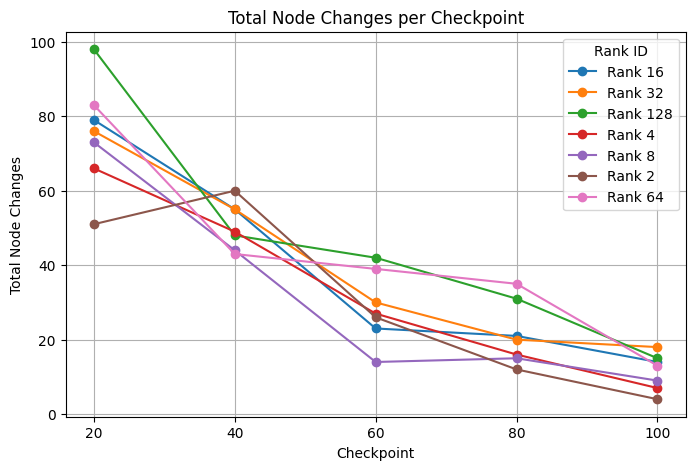

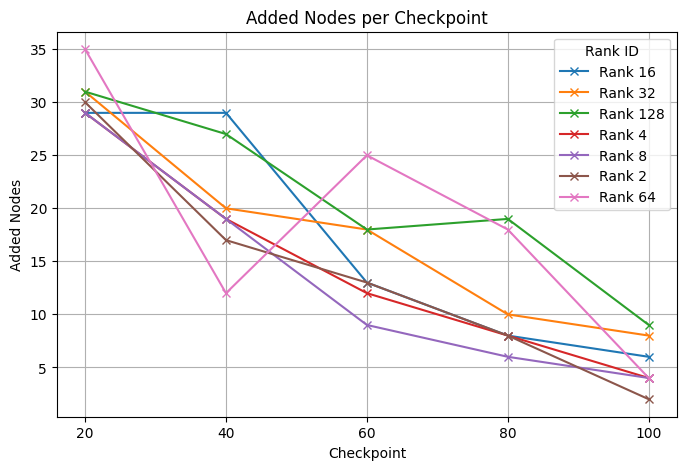

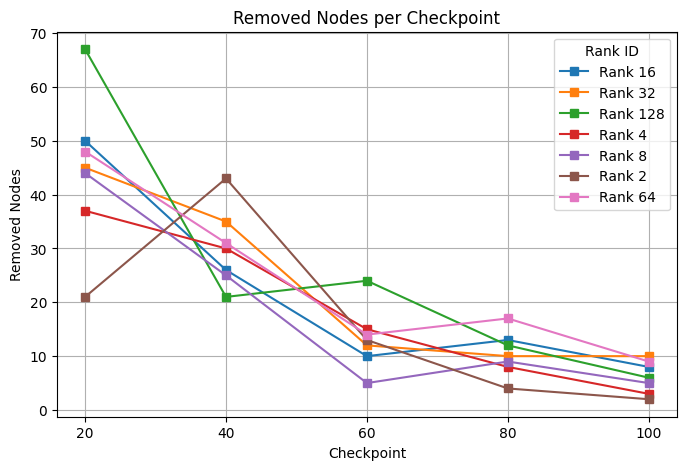

In [13]:
import matplotlib.pyplot as plt

checkpoints = ['20', '40', '60', '80', '100']

# Plot total changes
plt.figure(figsize=(8, 5))
for rank_id, values in node_changes.items():
    plt.plot(checkpoints, values['total_changes'], marker='o', label=f'Rank {rank_id}')
plt.xlabel('Checkpoint')
plt.ylabel('Total Node Changes')
plt.title('Total Node Changes per Checkpoint')
plt.legend(title='Rank ID')
plt.grid(True)
plt.show()

# Plot added nodes
plt.figure(figsize=(8, 5))
for rank_id, values in node_changes.items():
    plt.plot(checkpoints, values['added'], marker='x', label=f'Rank {rank_id}')
plt.xlabel('Checkpoint')
plt.ylabel('Added Nodes')
plt.title('Added Nodes per Checkpoint')
plt.legend(title='Rank ID')
plt.grid(True)
plt.show()

# Plot removed nodes
plt.figure(figsize=(8, 5))
for rank_id, values in node_changes.items():
    plt.plot(checkpoints, values['removed'], marker='s', label=f'Rank {rank_id}')
plt.xlabel('Checkpoint')
plt.ylabel('Removed Nodes')
plt.title('Removed Nodes per Checkpoint')
plt.legend(title='Rank ID')
plt.grid(True)
plt.show()